---


<h1 style="text-align:center"> 
Lung Cancer Classification using CT Data (Smoke Detector)
</h1><style>

---

## Introduction

> The integration of artificial intelligence (AI) into lung cancer screening represents a transformative approach to early detection and diagnosis, as lung cancer has a high mortality rate and many times it is diagnosed in the middle and late stages, when few therapies are available. The late diagnose happens beacause there are no obvious symptoms at an early stage **[2]**. With the ability to analyze complex medical data, AI enhances the identification of pulmonary nodules, ultimately improving patient outcomes. 

> Innovations such as low-dose computed tomography (LDCT) and computer-aided detection (CAD) systems enable precise characterization of nodules, facilitating personalized treatment strategies. As the field advances, ongoing research continues to explore the intersection of imaging techniques and AI, aiming to refine diagnostic processes and minimize the need for invasive procedures. **[1]**

--- 
## Libraries


In [2]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import get_malignancy_class, cluster_annots, get_cropped_annot
import pydicom
from radiomics import featureextractor
import SimpleITK as sitk
import os
from pathlib import Path
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#pylidc must be in lung-cancer-classification directory
print(pl.__file__)

/home/inesamorim46/3ano1sem/labiacd/proj_1/lung-cancer-classification/pylidc/__init__.py


---

## Importing XML files

In [4]:
nodule_counts_df = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
nodule_counts_df.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


> We chose not to use the Excel file containing nodule counts because it lacks the important information necessary for our analysis. Specifically, the file does not provide essential details about the characteristics or context of the nodules, which are necessary for accurately assessing their implications for lung cancer diagnosis and treatment.

In [5]:
pacient_data_df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
pacient_data_df.head()

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(pacient_data_df.shape)

(157, 14)


> We decided not to use the Excel file containing patient data from previous scans and cancers due to its limited scope, as it only includes information for about 10% of the patients studied. 

---


## Importing and Handling Annotations

> Although extracting features from CT Scans using Radiomics and Neural Networks provides information that is not yet seen by humans at first sight, most of the researchers don't believe these methods will replace the radiologists' role. Instead, using expert-reviwed data enhances the reliability of the features obtained, leading to better clinical outcomes **[3]**. Having this into account, it is still relevant to use the annotations features.


> As was done in **[4]**, the nodule annotations were used to obtain a consensus, where each feature is the average of the level assigned by each radiologist, rounded to the nearest integer. The code run to obtain this dataset is written and explained  in 'process_anns.ipynb'.

In [10]:
df_annotations = pd.read_csv('annotations_ds.csv', index_col=0)
df_annotations 

,ID,Scan_ID,Patient_ID,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,Internal Structure,Subtlety,Malignancy
0,2,1,LIDC-IDRI-0078,5,2,2,3,4,6,1,4,4
1,1,1,LIDC-IDRI-0078,4,2,3,3,4,6,1,5,4
2,8,1,LIDC-IDRI-0078,5,1,1,5,5,5,1,4,1
3,3,1,LIDC-IDRI-0078,5,3,3,3,4,5,1,5,4
4,16,2,LIDC-IDRI-0069,5,4,4,4,4,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2656,6850,1016,LIDC-IDRI-0639,3,3,2,2,4,6,1,4,4
2657,6851,1016,LIDC-IDRI-0639,1,2,1,2,4,6,1,2,4
2658,6856,1017,LIDC-IDRI-0638,5,1,2,4,4,6,1,3,4
2659,6855,1017,LIDC-IDRI-0638,5,1,1,5,4,6,1,5,2


---


###  Analysing Class Distribution from Data Extracted from Annotations

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

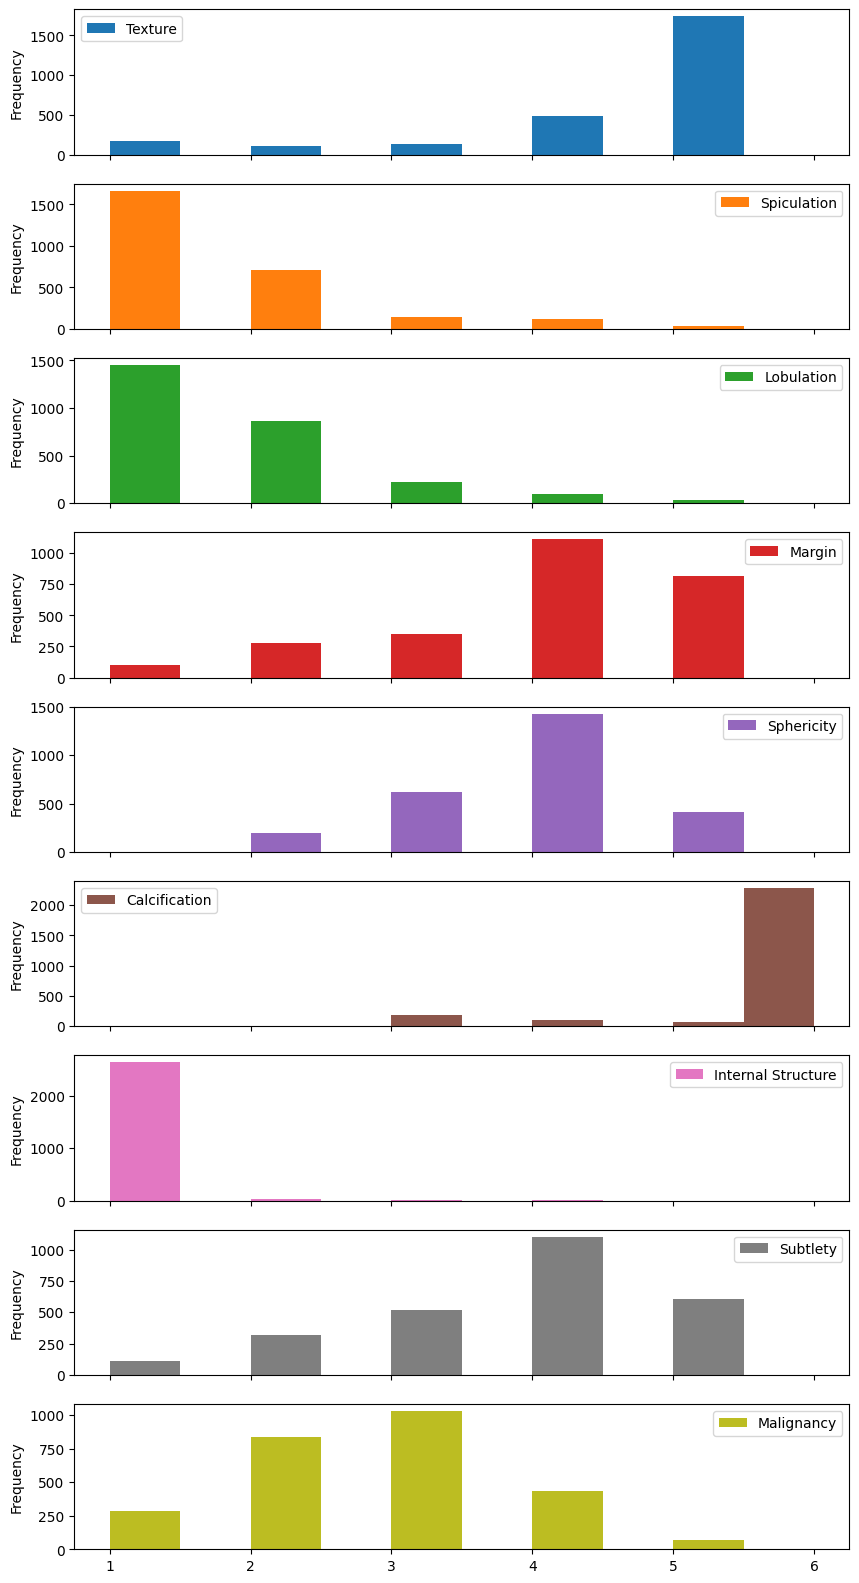

In [26]:
df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).plot(kind="hist", subplots=True, figsize=(10, 20))

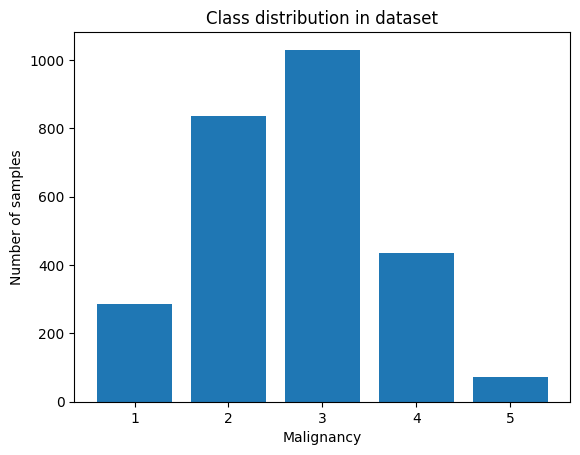

In [27]:
unique_labels, counts = np.unique(df_annotations["Malignancy"], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

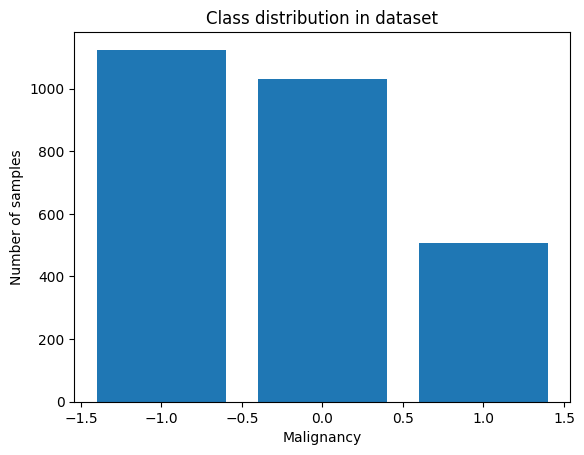

In [28]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)

unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

<AxesSubplot:>

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

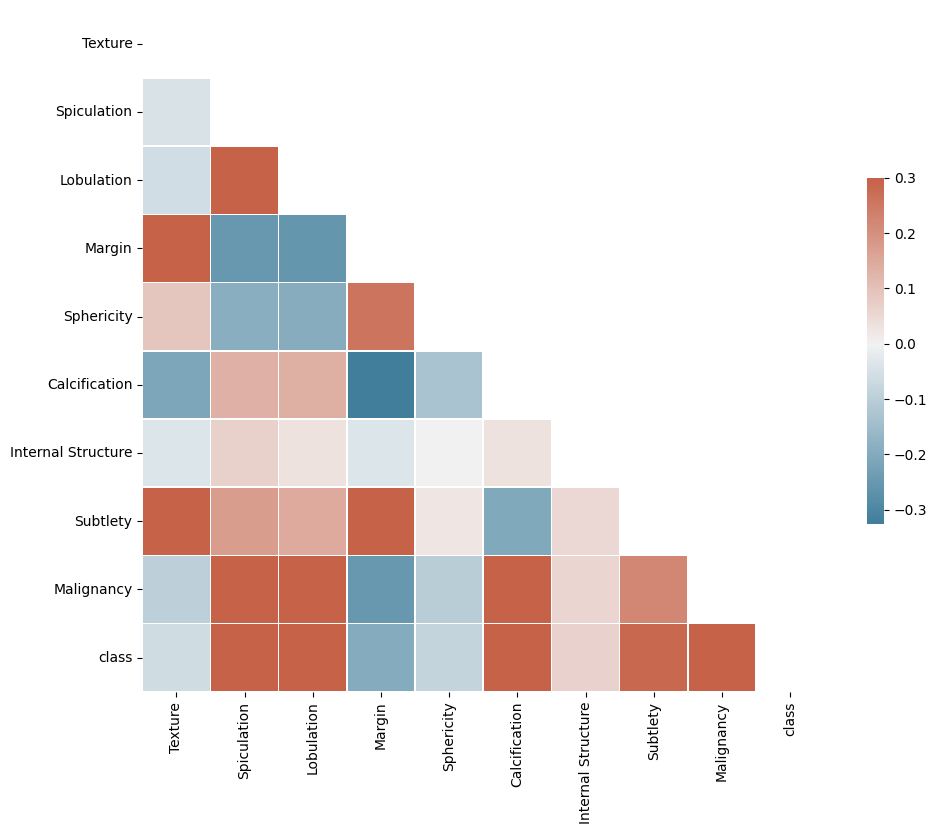

In [29]:
# Compute the correlation matrix
corr = df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

---

# DANI stuff

In [9]:
path_to_annotations = 'LIDC-XML-only'

In [ ]:
path = 'C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI'
f = open('C:/Users/Daniela/pylidc.conf', 'w')
f.write(f'[dicom]\npath = {path}\n\n')
f.close()

In [6]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [ ]:
vol = scan.to_volume()
print(vol.shape) # (dim, dim, depth)

plt.figure(figsize=(5, 5))
plt.imshow(vol[:,:,0])
plt.show() # show the first-level slice

In [ ]:
#extract information from an XML file
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()

    data = []
    for nodule in root

---

## Feature Extraction from CT Scans

These features describe various properties of the image, such as texture, shape, inetnsity, and spatial relationships, which may not be visible to the naked eye

### 1. Radiomics

In [3]:
df_radiomics = pd.read_csv('radiomics.csv')
df_radiomics

,Unnamed: 0,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient_id,nodule_id
0,0,0.823485,0.422484,3.597711,8.515614,8.062258,9.848858,10.049876,10.246951,139.958333,...,1.000000e+00,0.013514,5329.0,0.181343,1.392715,0.009703,0.000078,1.165431,LIDC-IDRI-0848,5523
1,1,0.822030,0.332701,5.249749,15.779186,19.026298,18.248288,15.000000,19.052559,747.750000,...,-3.203427e-16,0.001312,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1338
2,2,0.737988,0.325554,2.055999,6.315384,5.099020,7.071068,7.071068,7.141428,39.541667,...,-3.203427e-16,0.022222,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1339
3,3,0.594263,0.285487,14.952101,52.373975,45.177428,48.836462,56.515485,63.419240,9251.583333,...,1.298795e+00,0.000861,9426162.0,2.276169,0.110029,0.001955,0.000002,0.101741,LIDC-IDRI-0829,5630
4,4,0.935982,0.601938,4.003552,6.651108,7.280110,8.062258,7.211103,8.124038,110.583333,...,-3.203427e-16,0.008547,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0830,5627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2656,0.612233,0.352484,2.305650,6.541145,4.123106,7.280110,7.000000,7.348469,31.833333,...,-3.203427e-16,0.027027,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1700
2657,2657,0.789584,0.411954,2.864976,6.954600,8.000000,8.544004,6.082763,8.544004,74.750000,...,-3.203427e-16,0.012346,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1702
2658,2658,0.871072,0.394275,2.357012,5.978092,6.082763,6.403124,6.082763,7.280110,44.291667,...,-3.203427e-16,0.020000,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1699
2659,2659,0.824329,0.585070,6.185429,10.572110,9.848858,12.649111,12.529964,12.649111,393.375000,...,-3.203427e-16,0.002481,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0676,6581


### 2. CNN

---

## Binary vs Multiclass Classification

Studies have explored both binary and multiclass classification approaches for lung cancer detection, each with its own advantages, but both reasonable options.

> **Binary Classification** typically focuses on distinguishing between bening and malignant, making it simpler and often more efficient in clinical settings. 

> In contrast, **Multiclass Classification** can provide deeper insights into various lung cancer subtypes, which can inform treatment strategies. Research shows that multiclass models can enhance diagnostic accuracy by capturing the complexity of tumor presentations, although they may require larger datasets and more sophisticated algorithms. Apart from this, a multiclass classification can lead to a smaller number of false negatives and can give insight on which treatment to use. **[5]**

We chose to use Binary Classification, as our main goal is to categorize lung nodules into malignant and non-maligant categories and we found more studies than not that used this approach. However, using Multiclass Classification could be a work for the future.

---

## Data Cleaning

### 1. Nodule Classification Ajustment

Because we opted for Binary Classification, we need to reduce the 5 existing categories into 2. There are many ways to do this, some better that others.

> The general idea between studies that use this type of classification is to is to categorize the malignancy values below 3 (i.e, 1 and 2) as **benign** and the values above 3 (i.e, 4 and 5) as **malign**. In this case, the nodules with malignancy value of 3 are eliminated.

> Another option is to, instead of excluding the nodules with malignancy value of 3, includes these in the category of malignant, so there is not a loss in data. Assigning them as malignant is always better that to assigning them as the opposotive, as in medicine is considered worst to have a false-negative than a false-positive.

---

## Training and Classifying

> In our analysis, we will utilize XGBoost, Random Forest, and potentially Support Vector Machines (SVM) as our primary machine learning algorithms. These algorithms are particularly well-suited for our dataset, which comprises over 100 features extracted from the LIDC-IDRI dataset. The goal is to compare the performance of the 3.

### 1. XGBoost 

> XGBoost is known for its high performance and efficiency in handling large datasets with many features, as it employs a gradient boosting framework that optimizes model training

### 2. Random Forest

> Random Forest provides an ensemble learning approach, combining multiple decision trees to enhance predictive accuracy while also allowing us to assess feature importance through its built-in measures.

### 3. Support Vector Machine

> Support Vector Machines are effective for high-dimensional spaces and are particularly useful for binary classification tasks

---

## Performance Metrics

For our binary classification task, we used a set of performance metrics to evaluate the models' ability to correctly classify benign and malignant nodules. Here are the ones we found to be the most interesting:

1. **F1-Score:**  This balances **Precision** and **Recall**, providing a harmonic mean between the two. It is especialle useful when the dataset has imbalanced classes as it gives a good balance between false positives and false negatives.

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

2. **F2-Score:** This is a variation of the F1-score that gives more weight to the **Recall** when compared to the Precision. This is especially important in the medical field, where minimizing false negatives is crucial, because failing to detect a malignant nodule can have severe consequences.

$$
F2 = 5 \times \frac{\text{Precision} \times \text{Recall}}{4 \times \text{Precision} + \text{Recall}}
$$

3. **Precision:** Measures how many of the predicted postives are actually postives, in this case, it is used to ensure that the predictions marked as malignant are actually malignant.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

4. **Recall (Sensitivity):**  Focuses on how well the model identifies actuall positives. A high recall ensures that most malignant nodules are detected.


$$
\text{Recall} = \frac{TP}{TP + FN}
$$

5. **ROC AUC:** The Are Under Curve is used to measure the overall models' ability to distinguish between classes, as the ROC Curve plots the true positive rate against the false positive rate. AUC is a value between 0 and 1, where 1 indicates perfect classification and 0.5 represents random guessing.

6. **Balanced Accuracy:** This is the average of recall for both classes (benign and malignant), making it particularly useful when dealing with imbalanced datasets. It ensures that both classes are treated equally, avoiding bias towards the more frequent class. As we've seen before there is more cases of non-malignant nodules.

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

---

## Discussion and Conclusions

---

## References

- [1] Cellina, M., Cacioppa, L.M., Cè, M., Chiarpenello, V., Costa, M., Vincenzo, Z., Pais, D., Bausano, M.V., Rossini, N., Bruno, A. and Floridi, C. (2023). Artificial Intelligence in Lung Cancer Screening: The Future Is Now. Cancers, [online] 15(17), p.4344. doi:https://doi.org/10.3390/cancers15174344.

- [2] Lv, E., Liu, W., Wen, P. and Kang, X. (2021). Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction. Journal of Healthcare Engineering, 2021, pp.1–11. doi:https://doi.org/10.1155/2021/8769652.

- [3] Lee, G., Park, H., Bak, S.H. and Lee, H.Y. (2020). Radiomics in Lung Cancer from Basic to Advanced: Current Status and Future Directions. Korean Journal of Radiology, 21(2), p.159. doi:https://doi.org/10.3348/kjr.2019.0630.

- [4] Causey, J.L., Zhang, J., Ma, S., Jiang, B., Qualls, J.A., Politte, D.G., Prior, F., Zhang, S. and Huang, X. (2018). Highly accurate model for prediction of lung nodule malignancy with CT scans. Scientific Reports, 8(1). doi:https://doi.org/10.1038/s41598-018-27569-w.

- [5] Bhattacharjee, A., Sameh Rabea, Bhattacharjee, A., Elkaeed, E.B., R. Murugan, Refat, M., Ram Kumar Sahu, Shazly, G.A. and Salem, M. (2023). A multi-class deep learning model for early lung cancer and chronic kidney disease detection using computed tomography images. Frontiers in oncology, 13. doi:https://doi.org/10.3389/fonc.2023.1193746.

- Github.io. (2018). Scan — pylidc  documentation. [online] Available at: https://pylidc.github.io/scan.html [Accessed 15 Oct. 2024].